# Ideas on structure discovering

In [100]:
import random
import networkx as nx
import matplotlib.pyplot as plt

In [101]:
def insert_random(s, n, times):
    l=len(s)
    res = s[:]
    for i in range(0,times):
        pos = random.randint(0,len(res))
        res = res[:pos] + [ n[random.randint(0,len(n)-1)] ] + res[pos:]
    return res

In [102]:
def get_succesor_edges( traces ):
    edges = {}

    for this_trace in traces:
        for idx in range(0, len(this_trace)-1):
            partial_subtrace = this_trace[idx:]
            s0 = partial_subtrace.pop(0)
            try:
                k_plus_1 = partial_subtrace.index(s0)
            except:
                k_plus_1 = len(partial_subtrace)
            # This is the subtrace T, the maximal that not contains s0
            T=partial_subtrace[:k_plus_1]

            # Edges found:
            for si in T:
                e = (s0, si)
                if e in edges.keys():
                    edges[e] = edges[e] + 1
                else:
                    edges[e] = 1
    return edges

In [103]:
def cluster_same_freq(edges, threshold=0):
    weights = list(set(edges.values()))
    sorted(weights)
    groups = {}
    for e in edges.keys():
        w  = edges[e]
        if w in groups.keys():
            groups[w].append( e )
        else:
            groups[w] = [e]
            
    remove_smaller = []
    for w in groups.keys():
        if len( groups[w] ) < threshold:
            remove_smaller.append(w)
    for w in remove_smaller:
        del(groups[w])
        
    return groups
#     print(groups)

In [104]:
def testLeftNode(graph, serials=[]):

    candid=[]
    for serial in serials:
        # Test if Sk can be append at the left
        for Sk in [ Sk for (Sk, Sl) in graph.edges() if Sl == serial[0] ]:

            # Test (Sk, node) exists for all nodes
            if all( [(Sk,node) in graph.edges() for node in serial] ):
                
                # Continue the search to the left
                candid = candid + testLeftNode(graph, [[Sk] + serial] ) 

    return serials + candid

In [105]:
def get_maximal_serials(candidates, verbose=False):
    if len(candidates) <= 1:
        return candidates

    first, c2 = candidates[0], candidates[1:]

    if any( [ set(first).intersection(set(n)) for n in c2] ):
        if verbose:
            print("%s is already part of another" % first)
        return get_maximal_serials( c2, verbose )
    else:
        return [first] + get_maximal_serials( c2, verbose )
    

In [106]:
# symbols
s = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789!@#$%^&*()_+=-{}[]\|<>,./?")

## Single Serial Path Discovery

Any trace of the form ```ABCDE``` can be described by a single path without loops in a directed graph. If we define *noise* as any symbol in between the trace different from symbols of the trace we have the following examples:

In [107]:
# Serial Path
serial_path = list("ABCDEFG")
serial_path

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [108]:
noisy_symbols = s[32:60]
# noisy_symbols = s[9:65]
"".join(noisy_symbols)

'ghijklmnopqrstuvwxyz01234567'

In the set below, the goal is to automatically find the serial path ```ABCDE``` and discard the noise.

In [109]:
# Serial Path with random symbols
traces = []
for i in range(100): # Number of instances
    traces.append ( insert_random(serial_path, noisy_symbols, len(serial_path)*5 ))

for t in traces[:10]:
    print( "".join(t) )

iqvvyg7ikvAgziimpkvBymrCDkEFtgqrG02s1r7sgz
nqonxAzq4skB2C12hxyDugwEjxkmkFntv4krh4G5jy
3A47o7sBruksxnghkwo6ltCrz1101iDsoE1wFGmtsm
wApsB2olq3jptzvCtmqoqg3Dyl57ghusEsh2FgtG1l
Ar3k75s5lm5B6yiy0knrCDEs7vFj265i4x6w0j5Gwu
tz5tAkimwBq3ylCulvpjDsEr67nrplgx5zF42G1vhg
h5Avowoquojo1wB7jp0gj5o4vCDtiuhEhFh3izx5jG
Aj1Bn3jr6p0gi3567CD7E7uu7osF6G432nsyzvr6z5
At1nni3iioxhmpphwB6CixzzqoDg43u70wE5zFov0G
vhpgA1shz17umBsCzzD7EpFon5G20yqsgo6yjzh2ul


## Count successors edges of same symbol

Build an adjacency matrix that counts how many edges $(s_0, s_i)$ are in the trace $T=s_0 ... s_i ... s_k$ where $s_i  \neq s_0, \forall 0 < i <= k$

In [110]:
edges1 = get_succesor_edges(traces)

In [111]:
edges_group1 = cluster_same_freq(edges1)

In [112]:
G = {}
for weight in sorted(edges_group1.keys()):
    G[weight] = nx.DiGraph()
    G[weight].add_edges_from( edges_group1[weight] )
        

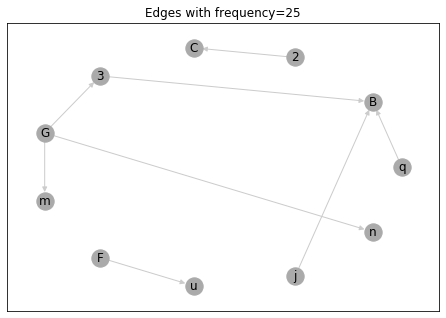

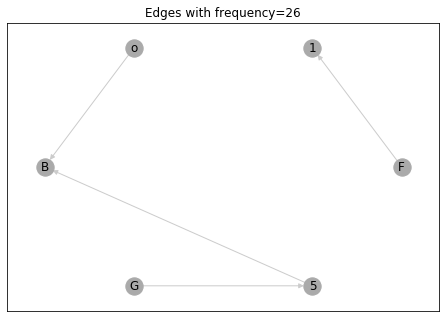

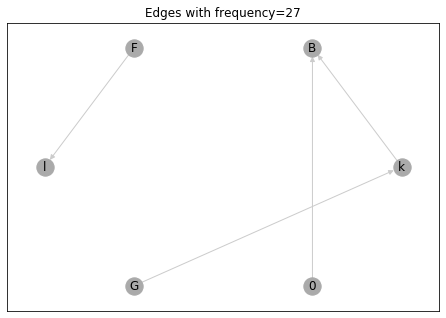

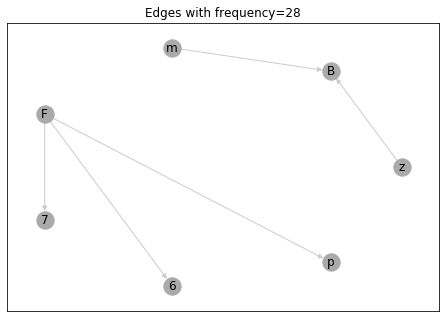

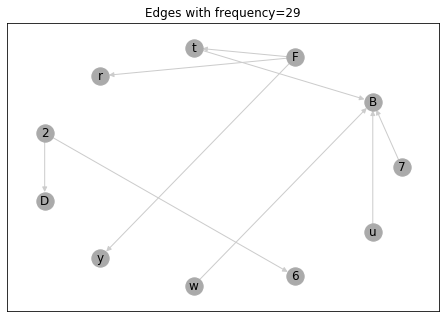

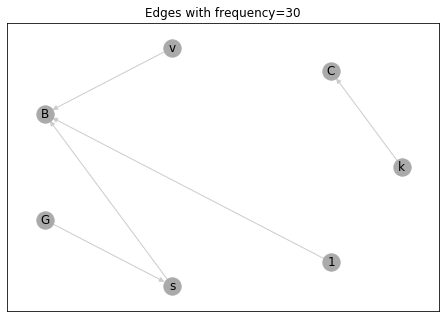

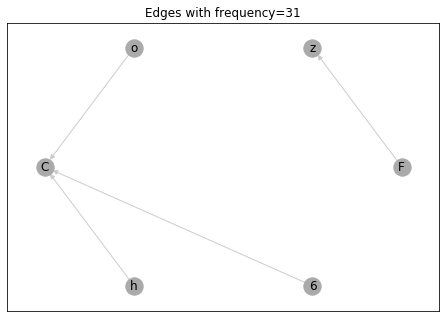

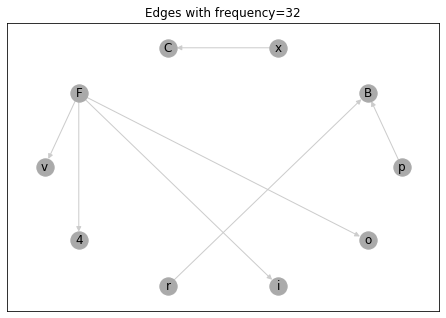

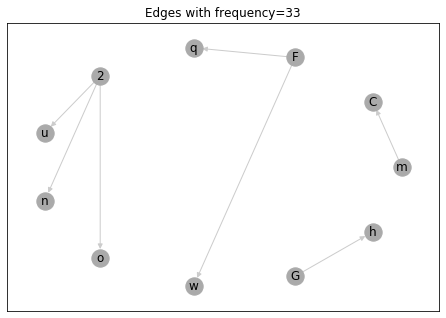

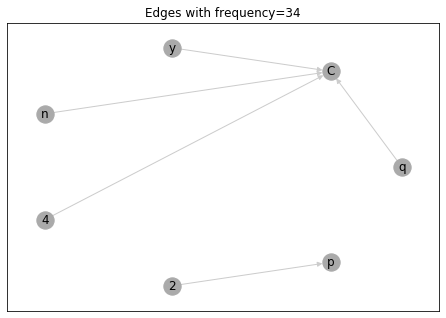

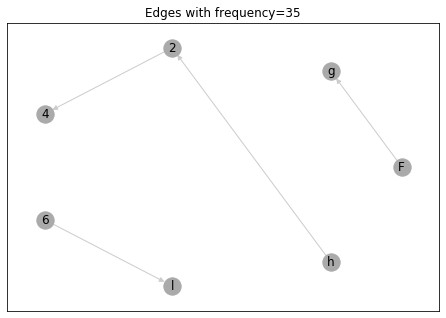

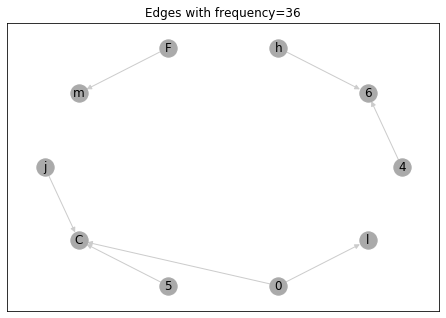

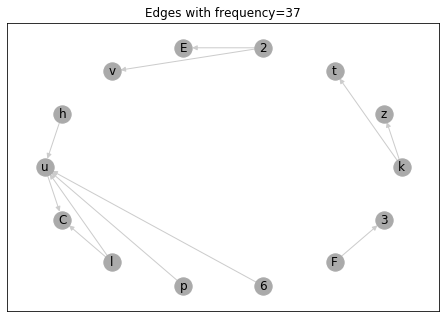

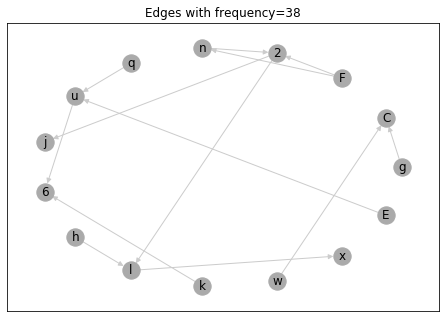

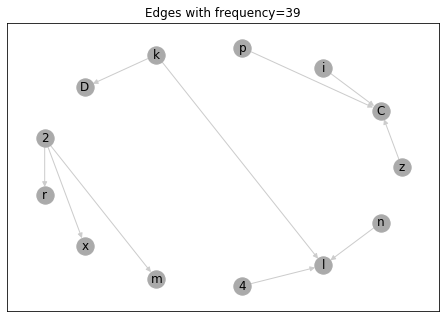

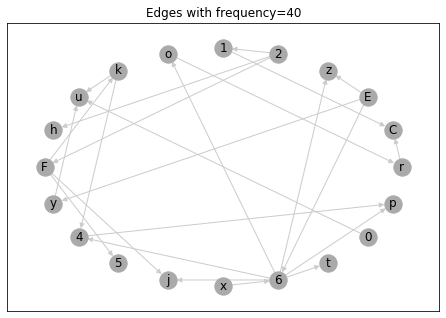

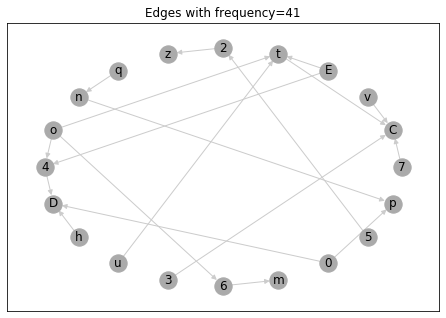

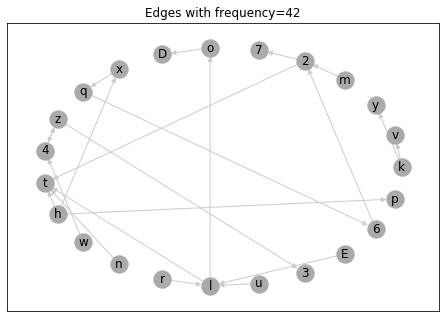

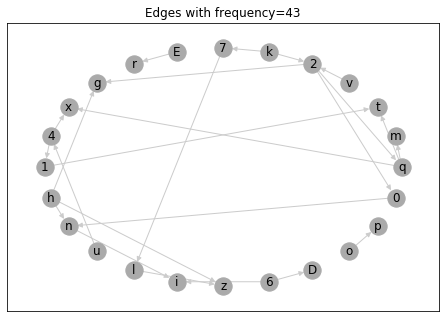

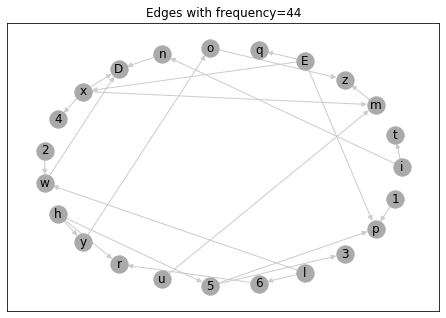

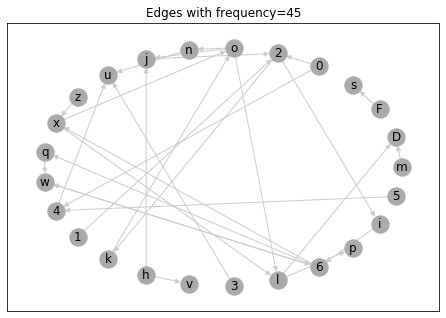

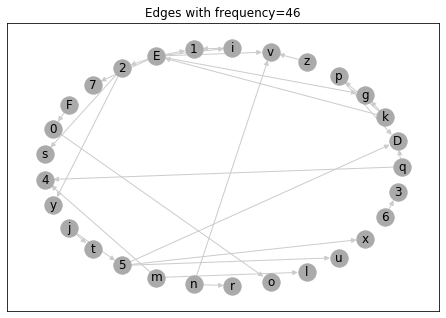

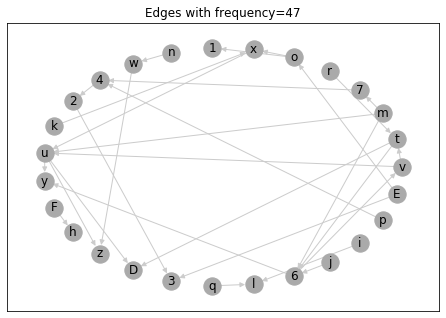

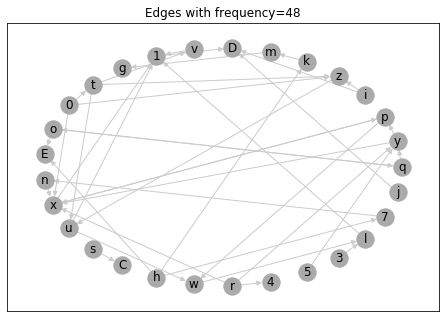

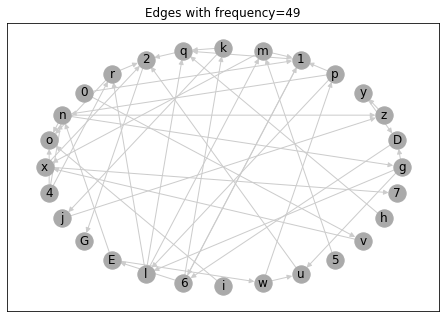

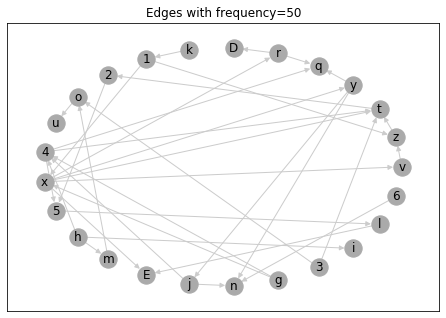

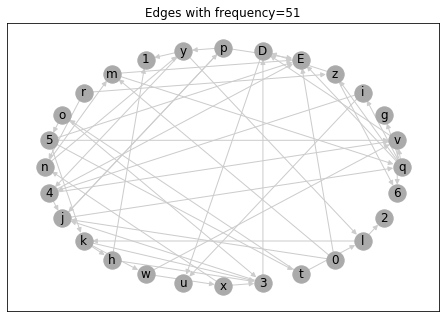

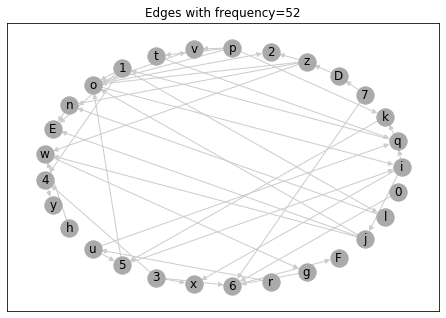

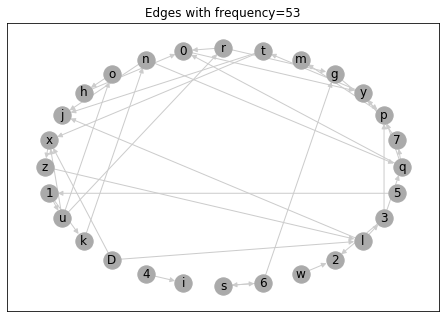

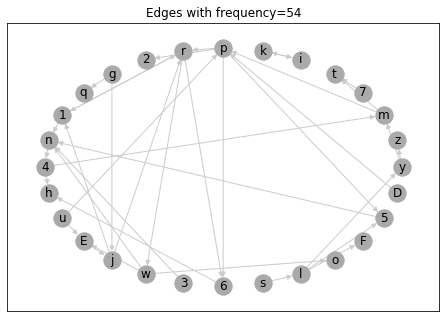

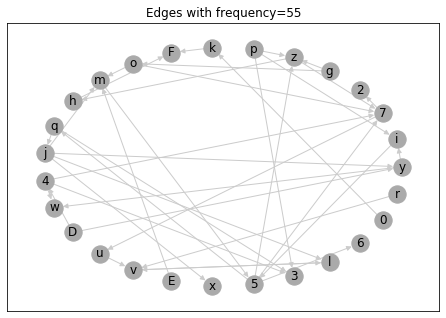

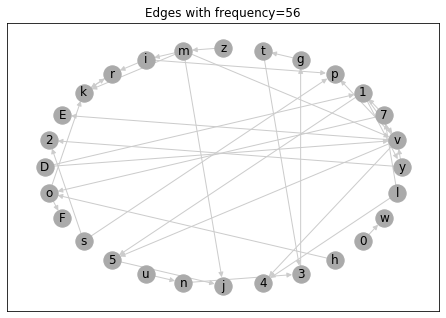

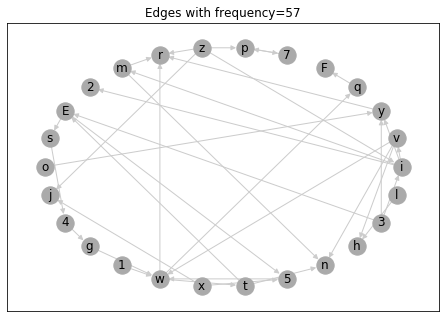

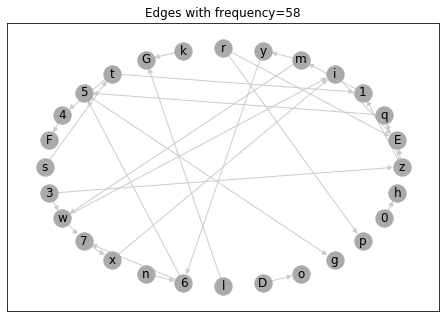

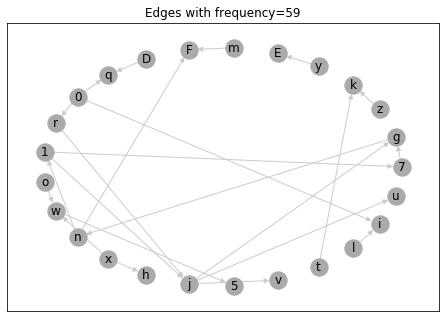

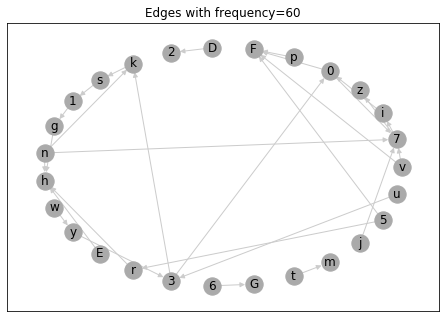

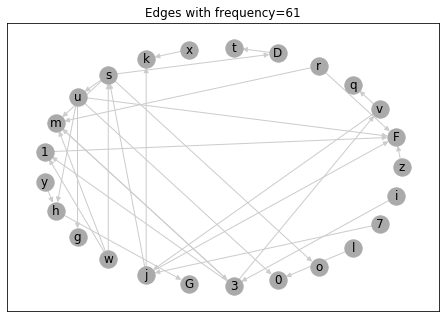

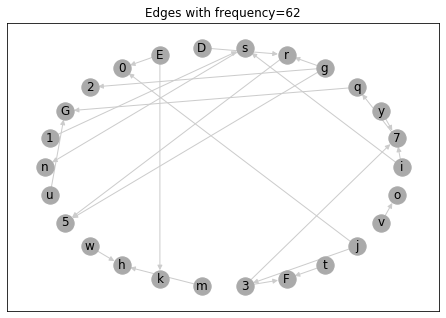

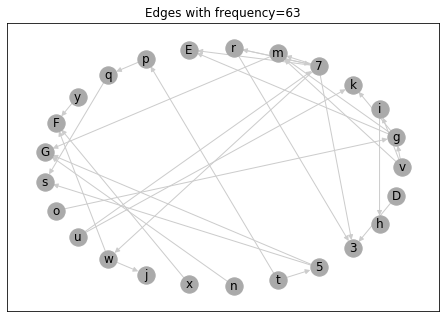

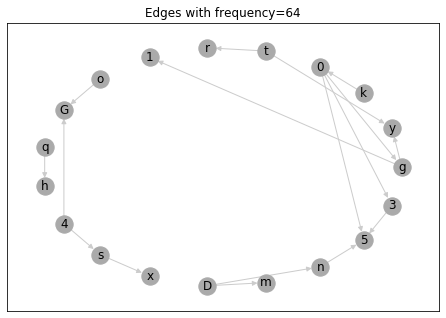

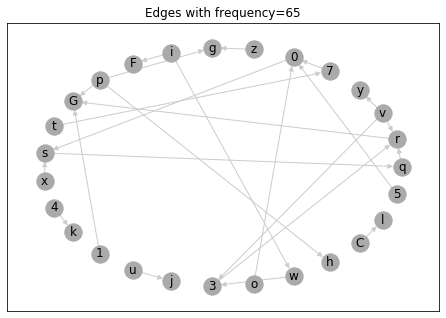

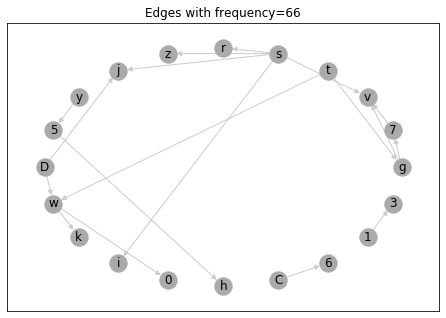

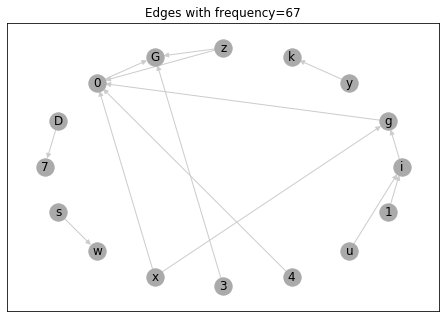

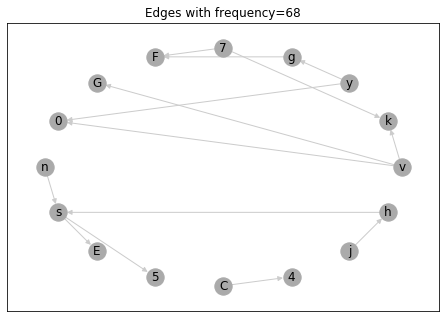

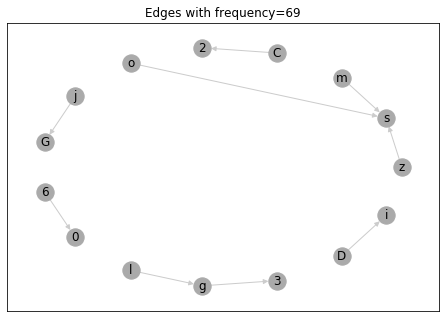

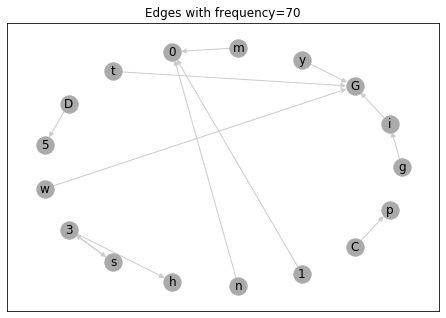

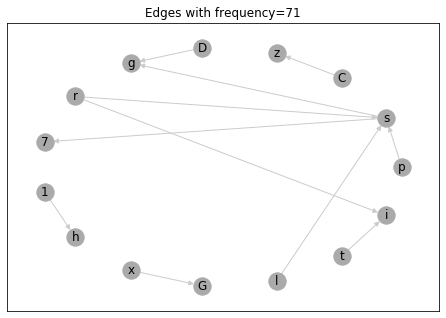

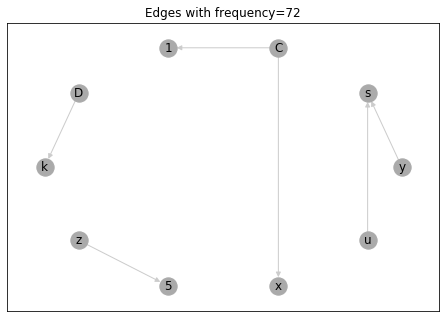

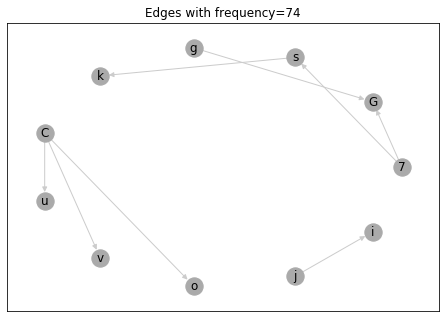

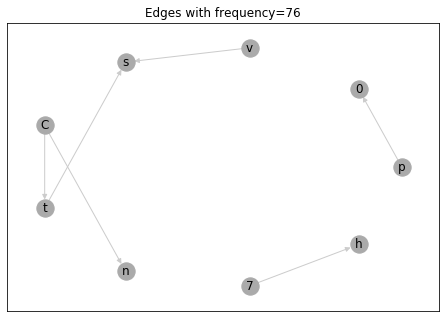

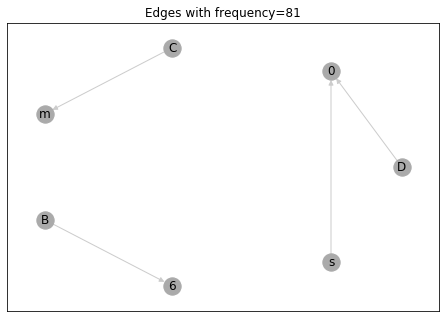

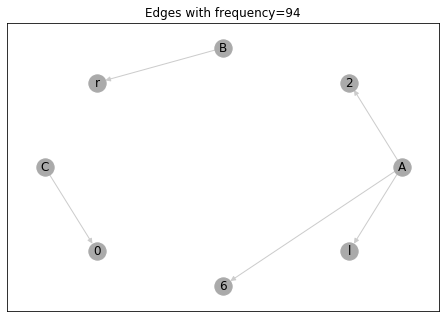

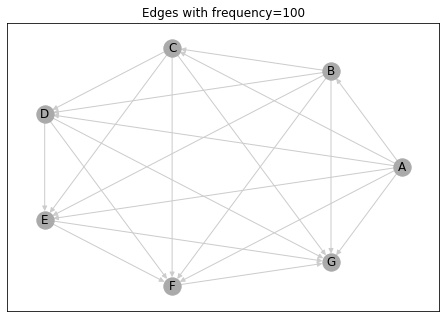

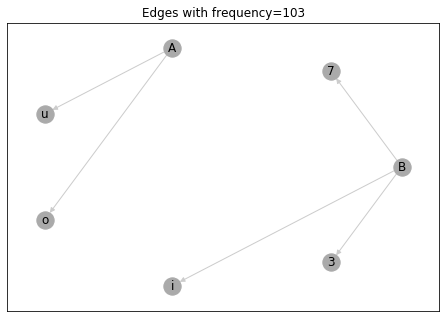

In [113]:
# Graph the candidates

MIN_EDGES_PER_FREQ=4 # min edges per group
MIN_FREQ=len(traces)/4

for weight in G.keys():
    if weight >= MIN_FREQ and len(edges_group1[weight]) >= MIN_EDGES_PER_FREQ:

        nx.draw_circular(G[weight], edge_color="#CCCCCC", node_color="#AAAAAA", with_labels=True)
        #Plot the graph
        plt.axis('on')
        plt.title('Edges with frequency=%d' % weight)
# #     plt.savefig("chess_legends.png") 
        plt.show() 

My claim is that a serial process $S=s_0...s_L$ will be shown as a graph made with the set of edges $(u,v)$ that appears the same amount of times in the set of traces $\Gamma$, and also the adjacency matrix of same frequency edges $M_{freq}$ can be chosen by reordering the nodes such that $\forall 0 < i, j < L$:

* $M_{ii}=0$
* $M_{ij}=1,  i < j $ (1 in upper diagonal)
* $M_{ij}=0,  j < i $ (0 in lower diagonal)

Note 1: that this $S$ is not necessarily unique.

Note 2: $M_{ii}=0$ by construction of the graph, given they have no loops.

In [114]:
nx.to_numpy_matrix(G[100])

matrix([[0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.]])

But... to check the permutations of $ N $ columns implies to check $N!$ possibilities. Then, a new method different than brute force must be found. 

A simple property (1) is that if a serial path $S$ contains the edges $(s_0, s_1)$, $(s_1, s_2)$, then $(s_0, s_2)$ must exists too. A stronger property (2) is going backward: if $s_{L-p}...s_{L-1}...s_l$ are the last $p$ elements of a serial path of lenght $L$, then a node $s_k$ can be added at the left iff the edges $(s_k, s_{L-q})$ exists for all $0 < q < p$. A third property (3) comes from the observation that any subset of $S$ is also a valid path, then the goal is to search the **maximal** serial path $S$ sharing the same nodes.

Then, let's search in the connection space... backward!

In [115]:
thisG = G[100]
candidates = []
for (u,v) in list(thisG.edges()):
    serial=[u,v]
    candidates = candidates + testLeftNode(thisG, [serial] )[1:]

In [116]:
for c in candidates:
    print(c)

['A', 'B', 'C']
['A', 'B', 'D']
['A', 'B', 'E']
['A', 'B', 'F']
['A', 'B', 'G']
['A', 'C', 'D']
['B', 'C', 'D']
['A', 'B', 'C', 'D']
['A', 'C', 'E']
['B', 'C', 'E']
['A', 'B', 'C', 'E']
['A', 'C', 'F']
['B', 'C', 'F']
['A', 'B', 'C', 'F']
['A', 'C', 'G']
['B', 'C', 'G']
['A', 'B', 'C', 'G']
['A', 'D', 'E']
['B', 'D', 'E']
['A', 'B', 'D', 'E']
['C', 'D', 'E']
['A', 'C', 'D', 'E']
['B', 'C', 'D', 'E']
['A', 'B', 'C', 'D', 'E']
['A', 'D', 'F']
['B', 'D', 'F']
['A', 'B', 'D', 'F']
['C', 'D', 'F']
['A', 'C', 'D', 'F']
['B', 'C', 'D', 'F']
['A', 'B', 'C', 'D', 'F']
['A', 'D', 'G']
['B', 'D', 'G']
['A', 'B', 'D', 'G']
['C', 'D', 'G']
['A', 'C', 'D', 'G']
['B', 'C', 'D', 'G']
['A', 'B', 'C', 'D', 'G']
['A', 'E', 'F']
['B', 'E', 'F']
['A', 'B', 'E', 'F']
['C', 'E', 'F']
['A', 'C', 'E', 'F']
['B', 'C', 'E', 'F']
['A', 'B', 'C', 'E', 'F']
['D', 'E', 'F']
['A', 'D', 'E', 'F']
['B', 'D', 'E', 'F']
['A', 'B', 'D', 'E', 'F']
['C', 'D', 'E', 'F']
['A', 'C', 'D', 'E', 'F']
['B', 'C', 'D', 'E', 'F']
['A

In [117]:
get_maximal_serials(candidates, verbose=True)

['A', 'B', 'C'] is already part of another
['A', 'B', 'D'] is already part of another
['A', 'B', 'E'] is already part of another
['A', 'B', 'F'] is already part of another
['A', 'B', 'G'] is already part of another
['A', 'C', 'D'] is already part of another
['B', 'C', 'D'] is already part of another
['A', 'B', 'C', 'D'] is already part of another
['A', 'C', 'E'] is already part of another
['B', 'C', 'E'] is already part of another
['A', 'B', 'C', 'E'] is already part of another
['A', 'C', 'F'] is already part of another
['B', 'C', 'F'] is already part of another
['A', 'B', 'C', 'F'] is already part of another
['A', 'C', 'G'] is already part of another
['B', 'C', 'G'] is already part of another
['A', 'B', 'C', 'G'] is already part of another
['A', 'D', 'E'] is already part of another
['B', 'D', 'E'] is already part of another
['A', 'B', 'D', 'E'] is already part of another
['C', 'D', 'E'] is already part of another
['A', 'C', 'D', 'E'] is already part of another
['B', 'C', 'D', 'E'] is 

[['A', 'B', 'C', 'D', 'E', 'F', 'G']]

In [119]:
# Now for all Graphs in G
for weight in G.keys():
    thisG = G[weight]
    candidates = []
    for (u,v) in list(thisG.edges()):
        serial=[u,v]
        candidates = candidates + testLeftNode(thisG, [serial] )[1:]
    maximals = get_maximal_serials(candidates)
    if len(maximals) > 0:
        print ("Serial Paths for frequency = %s" % weight)
        print(maximals)

Serial Paths for frequency = 37
[['l', 'u', 'C']]
Serial Paths for frequency = 38
[['F', 'n', '2']]
Serial Paths for frequency = 40
[['E', '6', 'z']]
Serial Paths for frequency = 45
[['x', 'o', 'l'], ['6', 'q', 'w']]
Serial Paths for frequency = 46
[['k', 'E', 'g']]
Serial Paths for frequency = 48
[['0', 't', 'z'], ['y', 'x', 'p']]
Serial Paths for frequency = 49
[['4', 'n', 'o']]
Serial Paths for frequency = 50
[['y', 'j', 'n']]
Serial Paths for frequency = 51
[['0', 'm', 'E'], ['k', 'h', '3']]
Serial Paths for frequency = 52
[['5', 'o', 'i']]
Serial Paths for frequency = 53
[['3', 'q', 'p']]
Serial Paths for frequency = 54
[['j', '1', 'r']]
Serial Paths for frequency = 55
[['5', 'z', '7']]
Serial Paths for frequency = 56
[['D', '1', 'v']]
Serial Paths for frequency = 57
[['3', 'i', 'y']]
Serial Paths for frequency = 61
[['w', 's', 'm']]
Serial Paths for frequency = 62
[['g', 'r', '5']]
Serial Paths for frequency = 63
[['v', 'g', 'm'], ['7', 'r', '3']]
Serial Paths for frequency = 64


## Conclusions

The algorithm is useful for a len(S) > 3, because the high probability to have the edge set:

$\{ (s_0, s_1), (s_1, s_2), (s_0, s_1)\}$

In contrast, the chances are far less to have the set in the same frequency range: 

$\{ (s_0, s_1), (s_1, s_2), (s_2, s_3), (s_0, s_1), (s_0, s_2), (s_0, s_3), (s_1, s_3)\}$

are dramatically lower.

## Pending tasks

1. Formal writting of the method
1. Test with several interleaved serial processes
1. Test with Observatory logs